## Code and Documentation to Decode Popup Buoy Transmitted/Recorded Data

## Software Requirements

Developed/tested for:
- python >=3.6 

requires:
- pyyaml >= 3.13 
- pandas >= 0.23.4
- numpy >= 1.15.4
- matplotlib >= 3.0.2
- jupyterlab >= 1.0.0 

## Data Structure

Data downloaded from Popup Buoy's directly, generate 8 binary files.  A complete description of these files can be found at **[link]**.  Relevant pieces will be included in the notebook.

Filenames:
- BOTDAT.TXT
- FILEPOS.TXT
- ICEDAT.TXT
- JPGxxxxx.JPG
- PRODAT.TXT
- SSTDAT.TXT
- SUMMARY.TXT

In [36]:
# 2018 - 300434063925210 - M5 : Inactive
# 2018 - 300434063823800 - C10/C11 Popup 102 : Active
# 2018 - 300434063921240 - C2 Popup 101 : Active
# 2018 - 300434063928220 - Popup 103 : Active

instid = '300434063921240'
year = '2019'
instfile_dic = {'bot_file': instid+'/'+year+'/BOTDAT.TXT',
                'ice_file': instid+'/'+year+'/ICEDAT.TXT',
                'pro_file': instid+'/'+year+'/PRODAT.TXT',
                'sst_file': instid+'/'+year+'/SSTDAT.TXT'}
instconfig = instid+'.yaml'

For each data file, we are going to read in the entire file and convert the binary to hex.  There are multiple line, lengths we are going to have to address but the start of each record is denoted by 'FFFF'.  We can split the filestring on this parameter but we need to be aware of 'FFFFF' or 'FFFFFF' posibilities

***Basic Approach***

The two modules below will allow for a simple readin of the file for very simple analysis and debugging... the code of consequence that involves conversion of measurements from engineering units to science units as all defined in the PopUpBuoy CLASS in the next section

In [37]:
def HexView(file):
    with open(file, 'rb') as in_file:
        while True:
            hexdata = in_file.read().hex().upper()     # Read the shortest possible line
            if len(hexdata) == 0:                      # breaks loop once no more binary data is read
                break
            
            return(hexdata.upper())
        
def HexSplit(hexstr):
    if hexstr.find('FFFFF') == -1:
        print("No FFFFF, proceed to split on FFFF")
        sample_raw = hexstr.split('FFFF')[1:]
    else:
        print('FFFFF found')
        #this puts in the proper line endings but removes a variable 
        #   F from the end of each string.  Add the F string back
        sample_raw = []
        for substr in hexstr.split('FFFFF')[1:]: 
            sample_raw = sample_raw + (substr + 'F').split('FFFF')

        sample_raw[-1] = sample_raw[-1][:-1]
        
    return(sample_raw)

In [38]:
active_file = instfile_dic['bot_file']

hexstr = HexView(active_file)
sample_raw = HexSplit(hexstr)


FFFFF found


# Class description and routine code

## Decode sample data for each file type

### Bottom Data (BOTDAT.TXT) / Under Ice Data (ICEDAT.TXT)

This data has two record lengths.  17 and 19.  Since we've split on 'FFFF' and broken the record up into samples, the initial 2bytes are no longer in the record so the record lengths are now 15 and 17 (which is a string length of 30 and 34 characters)

***MSG Decode Key***
![BotDecodeMsg](decode_images/BotDat_msg_decode.png)

***Engineering to Science Conversions***
![BotDecodeMsg](decode_images/BotDat_msg_cal.png)


### Profile Data (PRODAT.TXT) /

This data has two record lengths.  13 and 15.  Since we've split on 'FFFF' and broken the record up into samples, the initial 2bytes are no longer in the record so the record lengths are now 11 and 13 (which is a string length of 26 and 30 characters).  This file does not have the bottom temp or the reference temp fields.

***MSG Decode Key***
![ProDecodeMsg](decode_images/ProDat_msg_decode.png)

***Engineering to Science Conversions***
![ProCalMsg](decode_images/ProDat_msg_cal.png)

### SST Data (SSTDAT.TXT) /

This data has eight record lengths.  17 and 35, 18 and 36, 19 and 37 or 20 and 38.  Since we've split on 'FFFF' and broken the record up into samples, the initial 2bytes are no longer in the record so the record lengths are now 15 and 33, 16 and 34, 17 and 35 or 18 and 36.  The 8 types of files are if there is the short time format or the long time format, if TTS is provided or not, and if there is gps encoding or not for each of the time formats.

17: short-time, no gps, no TTS   
18: short-time, no gps, TTS   
19: long-time, no gps, no TTS   
20: long-time, no gps, TTS   
35: short-time, gps, no TTS   
36: short-time, gps, TTS   
37: long-time, gps, no TTS   
38: long-time, gps, TTS   

**UPDATE 3-12-2019:**  TTF is also an option now as an additional record of 2 bytes

***MSG Decode Key***
![SSTDecodeMsg](decode_images/SSTDat_msg_decode.png)

***Engineering to Science Conversions***
![SSTDecodeMsg](decode_images/SSTDat_msg_cal.png)

### Defining the PopUpBuoy Class

import functions

In [39]:
import numpy as np
import pandas as pd
import yaml
import collections

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, WeekdayLocator, MonthLocator, DayLocator, HourLocator, DateFormatter
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
from matplotlib.ticker import NullFormatter  # useful for `logit` scale

import datetime
from netCDF4 import num2date, date2num


preload matplotlib plot paramters

In [40]:
### specify primary bulk figure parameters
fontsize = 10
labelsize = 10
#plotstyle = 'seaborn'
#max_xticks = 10
plt.style.use('seaborn-ticks')
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['ps.fonttype'] = 42 #truetype/type2 fonts instead of type3
mpl.rcParams['pdf.fonttype'] = 42 #truetype/type2 fonts instead of type3
mpl.rcParams['axes.grid'] = False
mpl.rcParams['axes.edgecolor'] = 'black'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.labelcolor'] = 'black'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['xtick.major.size'] = 4
mpl.rcParams['xtick.minor.size'] = 2
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['xtick.minor.width'] = 0.5
mpl.rcParams['ytick.major.size'] = 4
mpl.rcParams['ytick.minor.size'] = 2
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.minor.width'] = 0.5
mpl.rcParams['ytick.direction'] = 'out'
mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['ytick.color'] = 'black'
mpl.rcParams['xtick.color'] = 'black'

mpl.rcParams['contour.negative_linestyle'] = 'solid'


In [41]:
def signed_int(hexstr):
    '''function to convert hex string to signed int'''
    s_int = int(hexstr,16)
    if s_int >= 0x8000:
        s_int -= 0x10000  

    return(s_int)

class PopUpBuoys(object):
    """Class definitions to read and Process PopUp Buoy Data Streams"""


    active_stream = 'bottom'
    def __init__(self, path):
        self.path = path
        self.instfile_dic = {'bottom': path + '/BOTDAT.TXT',
                             'ice': path + '/ICEDAT.TXT',
                             'profile': path + '/PRODAT.TXT',
                             'sst': path + '/SSTDAT.TXT'}
    
    def LoadCoefs(self, config_file='default.yaml'):
        ''' Load yaml formated config file '''
        self.config = yaml.safe_load(open(config_file))

    
    def HexView(self, active_stream='', verbose=True):
        '''
        input: reference to proper filepointer, options are keys 
            to the self.instfile_dic dictionary
        '''
        if active_stream:
            self.active_stream = active_stream
            
        file = self.instfile_dic[self.active_stream]
        with open(file, 'rb') as in_file:
            while True:
                hexdata = in_file.read().hex().upper()     
                if len(hexdata) == 0:                      
                # breaks loop once no more binary data is read
                    break
                self.hexstr = hexdata.upper()
                
                if verbose:
                    return(hexdata.upper())

    def HexSplit(self, verbose=True):
        '''
        input: results of HexView (inherits output)
        '''
        if self.hexstr.find('FFFFF') == -1:
            print("No FFFFF, proceed to split on FFFF")
            #because in this case the first index is empty
            sample_raw = self.hexstr.split('FFFF')[1:] 
        else:
            print('FFFFF found')
            #this puts in the proper line endings but removes a variable 
            #   F from the end of each string.  Add the F string back
            sample_raw = []
            for substr in self.hexstr.split('FFFFF'): 
                sample_raw = sample_raw + (substr + 'F').split('FFFF')

            sample_raw[-1] = sample_raw[-1][:-1]
        
        self.sample_raw = sample_raw
        
        if verbose:
            return(sample_raw)
    
    def Bottom(self, asPandas=False):
        ''' Bottom is equivalent to the TimeSeriesBase'''
        
        if self.active_stream != 'bottom':
            print("current active file is {} - can't output bottom data".format(self.active_stream))
            return

        data = self.TimeSeriesBase()

        if asPandas:
            data = pd.DataFrame.from_dict(data,orient='index')
        return(data)
    

    def Profile(self, asPandas=False):
        try:
            self.sample_raw
        except:
            print("Run PopUpBuoys.HexView and PopUpBuoys.HexSplit First")
            return

        if self.active_stream != 'profile':
            print("current active file is {} - can't output profile data".format(self.active_stream))
            return
                        
        data=collections.OrderedDict()

        for sample_num, sample in enumerate(self.sample_raw):
                        
            if len(sample) == 22: #2byte timeword
                
                # unlike sst, bottom, and ice - profiles don't need to be multiplied by a sample interval
                #seconds since 1970-01-01
                try:
                    time = int(sample[0:4],16)/100 + profile_starttime
                except:
                    time = int(sample[0:4],16)/100 + 0
                    
                pressure =  self.PressureConversion(int(sample[4:8],16)) 
                
                topside_temp_ADC = signed_int(sample[8:12])
                topside_temp = self.TempConversion(engr_meas=topside_temp_ADC,
                                                  coefA=self.config['topside_temp_cal']['Acoef'], 
                                                  coefB=self.config['topside_temp_cal']['Bcoef'],
                                                  coefC=self.config['topside_temp_cal']['Ccoef'])

                rawpvalue = signed_int(sample[12:16])                  
                par = self.PARConversion(engr_meas=rawpvalue,
                                        coef_offset=self.config['par_cal']['offset'], 
                                        coef_slope=self.config['par_cal']['slope'])   

                rawfvalue = signed_int(sample[16:20])                   
                fluor = self.FluorConversion(engr_meas=rawfvalue,
                                        coef_offset=self.config['fluor_cal']['offset'], 
                                        coef_slope=self.config['fluor_cal']['slope'])  

                tilt = int(sample[20:22],16) #degrees
                
            elif len(sample) == 26: #4byte timeword, reserved for profile starttime
                
                #seconds since 1970-01-01
                profile_starttime = int(sample[0:8],16)
                
                time = profile_starttime
                
                pressure =  self.PressureConversion(int(sample[8:12],16))  
                
                topside_temp_ADC = signed_int(sample[12:16])
                topside_temp = self.TempConversion(engr_meas=topside_temp_ADC,
                                                  coefA=self.config['topside_temp_cal']['Acoef'], 
                                                  coefB=self.config['topside_temp_cal']['Bcoef'],
                                                  coefC=self.config['topside_temp_cal']['Ccoef'])
                
                rawpvalue = signed_int(sample[16:20])             
                par = self.PARConversion(engr_meas=rawpvalue,
                                        coef_offset=self.config['par_cal']['offset'], 
                                        coef_slope=self.config['par_cal']['slope'])  

                rawfvalue = signed_int(sample[20:24])                
                fluor = self.FluorConversion(engr_meas=rawfvalue,
                                        coef_offset=self.config['fluor_cal']['offset'], 
                                        coef_slope=self.config['fluor_cal']['slope'])  

                tilt = int(sample[24:26],16) #degrees
            
            elif len(sample) == 0:
                continue
            else:
                continue # skip lines with too many data points
            #save to dictionary
            data[sample_num] = {'time':time,
                                'pressure':pressure,
                                'topside_temp':topside_temp,
                                'topside_temp_ADC':topside_temp_ADC,
                                'par':par,
                                'fluor':fluor,
                                'tilt':tilt}        
        
        if asPandas:
            data = pd.DataFrame.from_dict(data,orient='index')
        return(data)
        
    def Ice(self, asPandas=False):
        ''' Ice is equivalent to the TimeSeriesBase'''

        if self.active_stream != 'ice':
            print("current active file is {} - can't output ice data".format(self.active_stream))
            return

        data = self.TimeSeriesBase()

        if asPandas:
            data = pd.DataFrame.from_dict(data,orient='index')
        return(data)
    
    def SST(self, asPandas=False):
        ''' SST is equivalent to the TimeSeriesBase + GPS information'''
        
        if self.active_stream != 'sst':
            print("current active file is {} - can't output sst data".format(self.active_stream))
            return

        data = self.TimeSeriesBase()


        for sample_num, sample in enumerate(self.sample_raw):

            if (len(sample) == 30) or (len(sample) == 66): #2byte timeword, no TTS (w and w/o gps)
                TTS = np.nan
                if len(sample) == 66:
                    print("analyze GPS")
                    gps_data = self.GPSSeriesBase(sample_num, sample, empty=False)
                else:
                    gps_data = self.GPSSeriesBase(sample_num, sample, empty=True)

            elif (len(sample) == 32) or (len(sample) == 68): #2byte timeword, yes TTS (w and w/o gps)
                TTS = int(sample[30:32],16)
                if len(sample) == 68:
                    gps_data = self.GPSSeriesBase(sample_num, sample, offset=2, empty=False)
                else:
                    gps_data = self.GPSSeriesBase(sample_num, sample, empty=True)

            elif (len(sample) == 34) or (len(sample) == 70): #4byte timeword, no TTS (w and w/o gps)
                TTS = np.nan
                if len(sample) == 70:
                    gps_data = self.GPSSeriesBase(sample_num, sample, offset=4, empty=False)
                else:
                    gps_data = self.GPSSeriesBase(sample_num, sample, empty=True)

            elif (len(sample) == 36) or (len(sample) == 72): #4byte timeword, yes TTS (w and w/o gps)
                TTS = int(sample[30:32],16)
                if len(sample) == 72:
                    gps_data = self.GPSSeriesBase(sample_num, sample, offset=6, empty=False)
                else:
                    gps_data = self.GPSSeriesBase(sample_num, sample, empty=True)

            elif len(sample) == 0:
                continue
            else:
                continue # skip lines with too many data points
            #save to dictionary

            try:
                data[sample_num].update({'TTS':TTS})        
                data[sample_num].update(gps_data[sample_num])
            except:
                pass

        if asPandas:
            return(pd.DataFrame.from_dict(data,orient='index'))
        else:
            return(data)


    ### The folowing BASE functions are for convenience for reading and coding.  All redundant
    # pattern reads are below.  The only challenge is that each BASE function reads the entire hex
    # string (non-issue for files of size we expect)
    def GPSSeriesBase(self,sample_num, sample, offset=0, empty=True):
        '''SST only, the last 18 bytes are the same format:
         GPSLat, GPSLon, GPSDate, GPSTime, TTF, Max_Tilt
         Regardless of whether TTS or longdates are used.  This subroutine returns the 
         GPS dictionary based on a byte offset given the record length

         Passing empty=True sends missing data back for GPS Data'''
        data=collections.OrderedDict()

        if not empty:
            GPSLat = int(sample[30+offset:38+offset],16)/1000000
            GPSLon = (int(sample[38+offset:46+offset],16)- 4294967295) / 1000000
            GPSDate = int(sample[46+offset:54+offset],16)
            GPSTime = int(sample[54+offset:62+offset],16)
            TTF = int(sample[62+offset:64+offset],16)
            Max_Tilt = int(sample[62+offset:66+offset],16)   

        else:
            GPSLat = GPSLon = GPSDate = GPSTime = TTF = Max_Tilt = np.nan 
            
        #save to dictionary
        data[sample_num] = {'GPSLat':GPSLat,
                            'GPSLon':GPSLon,
                            'GPSDate':GPSDate,
                            'GPSTime':GPSTime,
                            'TTF':TTF,
                            'Max_Tilt':Max_Tilt}  
            
        return(data)   

    def TimeSeriesBase(self):
        '''Bottom, Ice, and SST all have the same base transmission information,
            e.g. the first 17 bytes (short time stamp) / 19 bytes (long time stamp)
            are the same.  Each of the the appropriate modules will call this communal module
            first.

            Bottom and Ice don't report any additional information beyond the base info so 
            they are essential decorators/wrappers for this function

            Returns: Dictionary'''
        try:
            self.sample_raw
        except:
            print("Run PopUpBuoys.HexView and PopUpBuoys.HexSplit First")
            return

        data=collections.OrderedDict()

        for sample_num, sample in enumerate(self.sample_raw):
            
            #record length conditionals are due to number of varying outputs
            #SST dominates the number of options due to:
            # 2byte timeword, no TTS, no GPS (30)
            # 4byte timeword, yes TTS, yes GPS (72)
            #  and every permutation of the three functions
            if ((len(sample) == 30) or (len(sample) == 32) or 
                            (len(sample) == 60) or (len(sample) == 64) or (len(sample) == 66) or (len(sample) == 68)) : #2byte timeword
                
                #seconds since 1970-01-01
                if self.active_stream in ['sst']:
                    #the correction is available for any non-utc setup pc
                    time_base = date2num(datetime.datetime.strptime(IDNUMBER.config['Unit_Release_Time'],
                                        '%Y-%m-%d %H:%M:%S'),
                                                                    'seconds since 1970-1-1')
                else:
                    time_base = 0 

                time = int(sample[0:4],16) * self.config['sample_interval'][self.active_stream] + time_base
                
                pressure =  self.PressureConversion(int(sample[4:8],16))  
                
                topside_temp_ADC = signed_int(sample[8:12])
                topside_temp = self.TempConversion(engr_meas=topside_temp_ADC,
                                                  coefA=self.config['topside_temp_cal']['Acoef'], 
                                                  coefB=self.config['topside_temp_cal']['Bcoef'],
                                                  coefC=self.config['topside_temp_cal']['Ccoef'])

                underside_temp_ADC = signed_int(sample[12:16])
                underside_temp = self.TempConversion(engr_meas=underside_temp_ADC,
                                                  coefA=self.config['underside_temp_cal']['Acoef'], 
                                                  coefB=self.config['underside_temp_cal']['Bcoef'],
                                                  coefC=self.config['underside_temp_cal']['Ccoef'])

                temp_ref = signed_int(sample[16:20])               
                
                rawpvalue = signed_int(sample[20:24])               
                par = self.PARConversion(engr_meas=rawpvalue,
                                        coef_offset=self.config['par_cal']['offset'], 
                                        coef_slope=self.config['par_cal']['slope']) 
                
                rawfvalue = signed_int(sample[24:28])                 
                fluor = self.FluorConversion(engr_meas=rawfvalue,
                                        coef_offset=self.config['fluor_cal']['offset'], 
                                        coef_slope=self.config['fluor_cal']['slope'])  

                tilt = int(sample[28:30],16) #degrees
                
            elif ((len(sample) == 34) or (len(sample) == 36) or (len(sample) == 72)) : #4byte timeword
                
                #seconds since 1970-01-01
                time = int(sample[0:8],16)
                
                pressure =  self.PressureConversion(int(sample[8:12],16))   
                
                topside_temp_ADC = signed_int(sample[12:16])
                topside_temp = self.TempConversion(engr_meas=topside_temp_ADC,
                                                  coefA=self.config['topside_temp_cal']['Acoef'], 
                                                  coefB=self.config['topside_temp_cal']['Bcoef'],
                                                  coefC=self.config['topside_temp_cal']['Ccoef'])

                underside_temp_ADC = signed_int(sample[16:20])
                underside_temp = self.TempConversion(engr_meas=underside_temp_ADC,
                                                  coefA=self.config['underside_temp_cal']['Acoef'], 
                                                  coefB=self.config['underside_temp_cal']['Bcoef'],
                                                  coefC=self.config['underside_temp_cal']['Ccoef'])

                temp_ref = signed_int(sample[20:24])          
                
                rawpvalue = signed_int(sample[24:28])                 
                par = self.PARConversion(engr_meas=rawpvalue,
                                        coef_offset=self.config['par_cal']['offset'], 
                                        coef_slope=self.config['par_cal']['slope'])  

                rawfvalue = signed_int(sample[28:32])               
                fluor = self.FluorConversion(engr_meas=rawfvalue,
                                        coef_offset=self.config['fluor_cal']['offset'], 
                                        coef_slope=self.config['fluor_cal']['slope'])  
                
                tilt = int(sample[32:34],16) #degrees            

            elif len(sample) == 0:
                continue
            else:
                continue # skip lines with too many data points
            #save to dictionary
            data[sample_num] = {'time':time,
                                'pressure':pressure,
                                'topside_temp':topside_temp,
                                'topside_temp_ADC':topside_temp_ADC,
                                'underside_temp':underside_temp,
                                'underside_temp_ADC':underside_temp_ADC,
                                'temp_ref':temp_ref,
                                'par':par,
                                'fluor':fluor,
                                'tilt':tilt}  
        return(data)

    @staticmethod
    def PARConversion(engr_meas,coef_offset, coef_slope):
        ''' Calculate PAR from raw measurement
        
            (ADC_val - coef_offset) * coef_slope / 0.73

            output is PAR in umolm-2s-1
        '''
        return((engr_meas - coef_offset) * coef_slope / 0.73 )

    @staticmethod
    def FluorConversion(engr_meas,coef_offset, coef_slope):
        ''' Calculate Fluometer from raw measurement

            (ADC_val - coef_offset) * coef_slope
        
            output is concentration in ug/L
        '''
        return((engr_meas - coef_offset) * coef_slope) 

    @staticmethod
    def PressureConversion(engr_meas):
        ''' Calculate Pressure from raw measurement

            (ADC_val - 16384) * 10 / 32768
        
            output is Pressure in Bars
        '''
        return((engr_meas - 16384) * 10 / 32768)

    @staticmethod
    def TempConversion(engr_meas, coefA, coefB, coefC):
        ''' Calculate Temperature from raw measurement.

        1 / ( coefA + 
              coefB*np.log10(ADC_val) + 
              coefC*np.log10(ADC_val)^3 ) - 273.15 

        Output is Temperature in DegC
        '''
        temperature = 1 / ( coefA + 
                     coefB*np.log10(engr_meas) + 
                     coefC*np.log10(engr_meas)**3 ) - 273.15        

        return(temperature)        

## Sample Evaluation of routine

Imagine a buoy with ID number **xxxxx**.  Instantiate a PopUpBuoys class with the relative (or absolute) path to the location of the download/reconstructed data files

In [42]:
IDNUMBER = PopUpBuoys(instid + '/'+year)

Load the configuration file.  If not specified it will load a file named 'default.yaml' in the same path as the utility

In [43]:
IDNUMBER.LoadCoefs(config_file=instconfig)

Call the routine to read and convert the binary file to a hex string... the sample parameter is the name of the data type.

active_stream options are:
+ bottom
+ sst
+ profile
+ ice

passing 'verbose=True' returns the hex string

In [44]:
IDNUMBER.HexView(active_stream='bottom',verbose=False)

In [45]:
IDNUMBER.HexSplit(verbose=False)

FFFFF found


In [46]:
bottom_data = IDNUMBER.Bottom(asPandas=True)

In [47]:
bottom_data

,time,pressure,topside_temp,topside_temp_ADC,underside_temp,underside_temp_ADC,temp_ref,par,fluor,tilt
1,0,0.026245,10.118169,10740,20.204270,10545,8510,-0.036795,-0.019259,84
2,3600,0.026855,9.839179,10885,19.734952,10771,8510,-0.036795,-0.019259,84
3,7200,0.026550,9.726856,10944,19.593874,10840,8510,-0.036795,0.000000,84
4,10800,0.026550,9.583170,11020,19.595912,10839,8510,-0.036795,0.000000,84
5,14400,0.027161,9.377168,11130,19.383137,10944,8510,-0.036795,0.000000,84
...,...,...,...,...,...,...,...,...,...,...
5425,19526400,3.995972,-10.141035,30288,-1.725006,30313,8508,-0.073589,0.134810,0
5426,19530000,3.996887,-10.141641,30289,-1.725648,30314,8508,-0.073589,0.096293,1
5427,19533600,3.997192,-10.142246,30290,-1.726291,30315,8508,-0.073589,0.096293,0
5428,19537200,3.995972,-10.142852,30291,-1.726933,30316,8508,-0.073589,0.154068,0


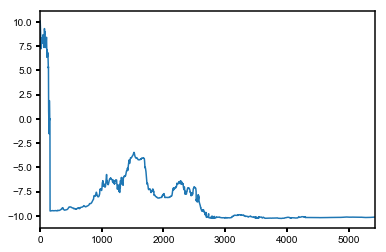

In [48]:
bottom_data.topside_temp.plot()
#bottom_data.pressure.plot()

In [49]:
IDNUMBER.HexView(active_stream='ice',verbose=False)
IDNUMBER.HexSplit(verbose=False)
ice_data = IDNUMBER.Ice(asPandas=True)

No FFFFF, proceed to split on FFFF


In [50]:
IDNUMBER.HexSplit(verbose=False)


No FFFFF, proceed to split on FFFF


In [51]:
IDNUMBER.Ice(asPandas=True)

,time,pressure,topside_temp,topside_temp_ADC,underside_temp,underside_temp_ADC,temp_ref,par,fluor,tilt
0,10800,0.180054,-10.164033,30326,-1.737204,30332,8508,2.042096,0.134810,2
1,14400,0.179749,-10.170684,30337,-1.740412,30337,8508,1.618959,0.096293,2
2,18000,0.179749,-10.176729,30347,-1.742337,30340,8508,1.159027,0.173327,2
3,21600,0.178833,-10.179750,30352,-1.744262,30343,8508,0.735890,0.462205,2
4,25200,0.178833,-10.180958,30354,-1.745545,30345,8508,0.202370,0.269620,2
...,...,...,...,...,...,...,...,...,...,...
1424,5137200,0.055237,-8.224075,27300,1.378082,25885,8509,1.747740,0.597015,3
1425,5140800,0.052490,-7.319729,26006,1.821130,25314,8509,1.011849,0.500722,4
1426,5144400,0.043945,-7.535225,26308,1.448723,25793,8509,2.777986,0.597015,4
1427,5148000,0.041199,-7.229713,25881,1.646004,25538,8509,3.734644,0.693308,1


In [52]:
hxv = IDNUMBER.HexView(active_stream='profile',verbose=True)
hs = IDNUMBER.HexSplit(verbose=True)
pro_data = IDNUMBER.Profile(asPandas=True)

FFFFF found


In [53]:
hs[98:110]

['09474F2B76711558000E04',
 '09604ED976711559000E06',
 '09794E8476711559001209',
 '09924E337671155A000F0A',
 '09AB4DDE7671155B001107',
 '09C44D867671155B000D05',
 '09DD4D2D7671155C000F04',
 '09F64CD57671155D001304',
 '0A0F4C7E7671155D001406',
 '0A284C297671155E001709',
 '0A414BD47671155F001009',
 '0A5A4B807671155F001209']

In [54]:
pro_data

,time,pressure,topside_temp,topside_temp_ADC,par,fluor,tilt
2,1.556638e+09,3.697205,-10.159194,30318,-0.073589,0.346654,4
3,1.556638e+09,3.692932,-10.159194,30318,-0.073589,0.346654,5
4,1.556638e+09,3.667908,-10.159194,30318,-0.073589,0.250361,8
5,1.556638e+09,3.643188,-10.159799,30319,-0.073589,0.231103,11
6,1.556638e+09,3.617859,-10.159799,30319,-0.073589,0.423688,10
...,...,...,...,...,...,...,...
359,1.556638e+09,0.180969,-10.171289,30338,2.612411,0.462205,2
360,1.556638e+09,0.181274,-10.171289,30338,2.612411,0.327395,2
361,1.556638e+09,0.180969,-10.171289,30338,2.612411,0.211844,2
362,1.556638e+09,0.181274,-10.171289,30338,2.612411,0.192585,2


In [55]:
hxv = IDNUMBER.HexView(active_stream='sst',verbose=True)
hs = IDNUMBER.HexSplit(verbose=True)
sst_data = IDNUMBER.SST(asPandas=True)


FFFFF found


In [56]:
#hs

## Profile Plotting Fun

Since a pandas dataframe is a native output, quicklook plots are very easy to obtain as are output to csv for other software

/Users/bell/anaconda2/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  after removing the cwd from sys.path.


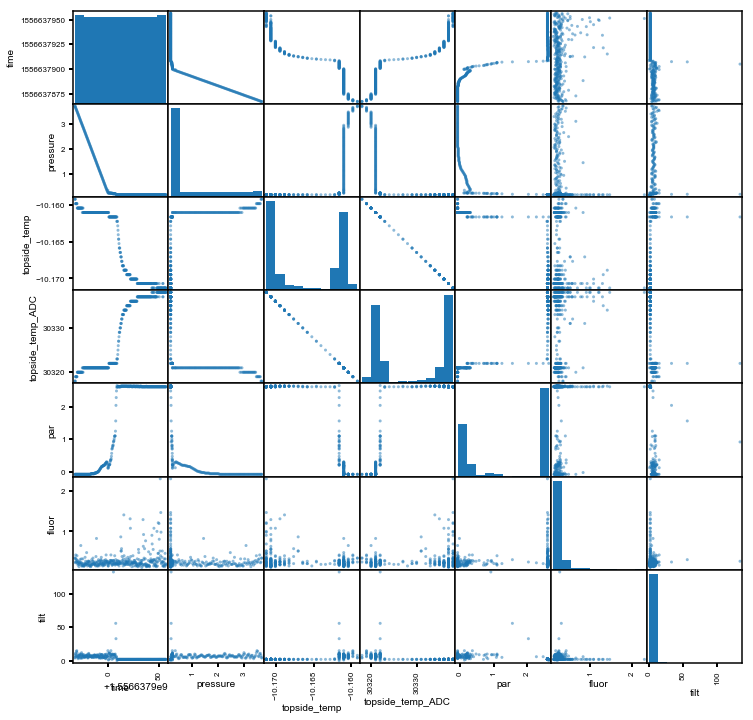

In [57]:
#%matplotlib inline
fig = plt.figure(figsize=(12, 12))
ax1 = plt.subplot(1, 1, 1)
pd.plotting.scatter_matrix(pro_data, ax=ax1)
fig.savefig(instid + '/'+year + '/' + instid+'_profile_data.facetgrid.png',dpi=300, tight_layout=True)

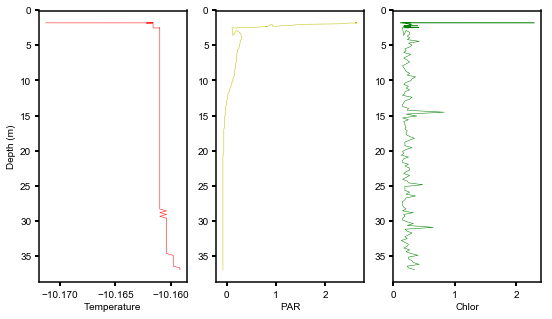

In [58]:
fig = plt.figure(1,figsize=(9,5))
### CTD Temperature
ax1 = plt.subplot(1, 3, 1)
plt.plot(pro_data.topside_temp,pro_data.pressure*10,'r',linewidth=.5)
ax1.invert_yaxis()
ax1.set_xlabel('Temperature')
ax1.set_ylabel('Depth (m)')
### CTD PAR
ax1 = plt.subplot(1, 3, 2)
plt.plot(pro_data.par,pro_data.pressure*10,'y',linewidth=.5)
ax1.invert_yaxis()
ax1.set_xlabel('PAR')
### CTD Temperature
ax1 = plt.subplot(1, 3, 3)
plt.plot(pro_data.fluor,pro_data.pressure*10,'g',linewidth=.5)
ax1.invert_yaxis()
ax1.set_xlabel('Chlor')

fig.savefig(instid + '/'+year + '/' + instid+'_pro_data.simple.png',dpi=300)

### Convert elapse time to datetime

In [59]:
#time functions are in netcdf4 library
pro_data['datetime'] =[num2date(x['time'],'seconds since 1970-1-1') for i,x in pro_data.iterrows()]

Profile data spells out the profile start time which is used to create the "datetime" variable

In [60]:
pro_data['datetime']

2     2019-04-30 15:24:27.000
3     2019-04-30 15:24:27.000
4     2019-04-30 15:24:27.250
5     2019-04-30 15:24:27.500
6     2019-04-30 15:24:27.750
                ...          
359   2019-04-30 15:25:56.000
360   2019-04-30 15:25:56.250
361   2019-04-30 15:25:56.500
362   2019-04-30 15:25:56.750
363   2019-04-30 15:25:57.000
Name: datetime, Length: 362, dtype: datetime64[ns]

Bottom and Ice data start marking time from the "Unit_Start_Time" and "Unit_Release_Time" which should be incorporated into the config file

In [61]:
print(yaml.dump(IDNUMBER.config, default_flow_style=False))

Deploy_Depth: 44.2
Deploy_LatN: 71.222833
Deploy_LonW: 164.2613
PopUP_SN: 101
UnitID: 300434063921240
Unit_Deploy_Time: '2018-8-14 06:38:00'
Unit_Release_Time: '2019-4-30 23:00:00'
Unit_Start_Time: '2018-8-7 08:00:00'
fluor_cal:
  offset: 4
  slope: 0.01925854598
par_cal:
  offset: 5462
  slope: 0.01343
sample_interval:
  bottom: 3600
  ice: 3600
  sst: 3600
topside_temp_cal:
  Acoef: 0.001271116
  Bcoef: 0.0005419057
  Ccoef: 1.14021e-06
underside_temp_cal:
  Acoef: 0.001195472
  Bcoef: 0.00052877341
  Ccoef: 1.3222558e-06



In [62]:
bottom_data['datetime'] =[num2date(x['time'],'seconds since '+ str(IDNUMBER.config['Unit_Start_Time']) ) for i,x in bottom_data.iterrows()]

Trim out deck data using deploy date in config file for output csv files

In [63]:
bottom_data = bottom_data.drop(bottom_data[bottom_data['datetime'] < IDNUMBER.config['Unit_Deploy_Time']].index)

In [64]:
ice_data['datetime'] =[num2date(x['time'],'seconds since '+ str(IDNUMBER.config['Unit_Release_Time']) ) for i,x in ice_data.iterrows()]
ice_data['datetime']

0      2019-05-01 02:00:00
1      2019-05-01 03:00:00
2      2019-05-01 04:00:00
3      2019-05-01 05:00:00
4      2019-05-01 06:00:00
               ...        
1424   2019-06-29 10:00:00
1425   2019-06-29 11:00:00
1426   2019-06-29 12:00:00
1427   2019-06-29 13:00:00
1428   2019-06-29 14:00:00
Name: datetime, Length: 1429, dtype: datetime64[ns]

In [65]:
try:
    sst_data['datetime'] =[num2date(x['time'],'seconds since 1970-1-1') for i,x in sst_data.iterrows()]
    sst_data['datetime']
except:
    print("No SST data")
sst_data['datetime']
    
#filter out any dates that are before the deployment date
#sst_data = sst_data[sst_data.datetime>IDNUMBER.config['Unit_Start_Time']]

1      2019-06-29 07:30:53
2      2019-06-29 07:51:03
3      2019-06-29 08:15:27
4      2019-06-29 09:04:25
5      2019-06-29 09:31:08
               ...        
1236   2019-10-24 17:00:00
1237   2019-10-24 20:00:00
1238   2019-10-24 23:00:00
1239   2019-10-25 02:00:00
1240   2019-10-25 05:00:00
Name: datetime, Length: 1240, dtype: datetime64[ns]

### Saving Data to be used in other software

simple as sending the pandas dataframe to csv

In [66]:
#add id,lat,lon from config to datafiles
try:
    ice_data['id'] = IDNUMBER.config['UnitID']
    ice_data['dep_lat'] = IDNUMBER.config['Deploy_LatN']
    ice_data['dep_lon'] = IDNUMBER.config['Deploy_LonW']
    ice_data.to_csv(instid + '/'+year + '/' + instid+'_ice_data.csv')
except:
    print("No under Ice data")
try:
    sst_data['id'] = IDNUMBER.config['UnitID']
    sst_data['dep_lat'] = IDNUMBER.config['Deploy_LatN']
    sst_data['dep_lon'] = IDNUMBER.config['Deploy_LonW']
    sst_data.to_csv(instid + '/'+year + '/' + instid+'_sst_data.csv')
except:
    print("No SST data")
try:
    bottom_data['id'] = IDNUMBER.config['UnitID']
    bottom_data['dep_lat'] = IDNUMBER.config['Deploy_LatN']
    bottom_data['dep_lon'] = IDNUMBER.config['Deploy_LonW']
    bottom_data.to_csv(instid + '/'+year + '/' + instid+'_bottom_data.csv')
except:
    print("No bottom data")  
try:
    pro_data['id'] = IDNUMBER.config['UnitID']
    pro_data['dep_lat'] = IDNUMBER.config['Deploy_LatN']
    pro_data['dep_lon'] = IDNUMBER.config['Deploy_LonW']
    pro_data.to_csv(instid + '/'+year + '/' + instid+'_profile_data.csv')
except:
    print("No bottom data")

## Timeseries Plots of Bottom/Ice/SST

*Bottom*

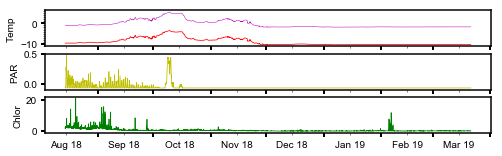

In [67]:
fig = plt.figure(1,figsize=(8,2.5))
### CTD Temperature
ax1a = plt.subplot(3, 1, 1)
plt.plot(bottom_data.datetime,bottom_data.topside_temp,'r',linewidth=.75)
plt.plot(bottom_data.datetime,bottom_data.underside_temp,'m',linewidth=.5)
ax1a.set_xticklabels([])
ax1a.set_ylabel('Temp')
### Par
ax1b = plt.subplot(3, 1, 2)
plt.plot(bottom_data.datetime,bottom_data.par,'y',linewidth=.75)
ax1b.set_xticklabels([])
ax1b.set_ylabel('PAR')
### Chlor
ax1c = plt.subplot(3, 1, 3)
plt.plot(bottom_data.datetime,bottom_data.fluor,'g',linewidth=.75)
ax1c.set_ylabel('Chlor')


## specify datelabels and ticks for all three pannels
ax1a.yaxis.set_minor_locator(ticker.MultipleLocator(1))
ax1a.xaxis.set_major_locator(DayLocator(bymonthday=1))
ax1a.xaxis.set_minor_locator(DayLocator(bymonthday=15))
#ax1b.yaxis.set_minor_locator(ticker.MultipleLocator(2.5))
ax1b.xaxis.set_major_locator(DayLocator(bymonthday=1))
ax1b.xaxis.set_minor_locator(DayLocator(bymonthday=15))

ax1c.tick_params(labelbottom=True,labeltop=False)
#ax1c.yaxis.set_minor_locator(ticker.MultipleLocator(2.5))
ax1c.xaxis.set_major_locator(DayLocator(bymonthday=1))
ax1c.xaxis.set_minor_locator(DayLocator(bymonthday=15))
ax1c.xaxis.set_major_formatter(ticker.NullFormatter())
ax1c.xaxis.set_minor_formatter(DateFormatter('%b %y'))
ax1c.xaxis.set_major_formatter(DateFormatter(''))
ax1c.xaxis.set_tick_params(which='major', pad=15)
ax1c.xaxis.set_tick_params(which='minor', pad=5)

fig.subplots_adjust(bottom=0.2)
fig.savefig(instid + '/'+year + '/' + instid+'_bottom_data.png',dpi=300)

### Under Ice

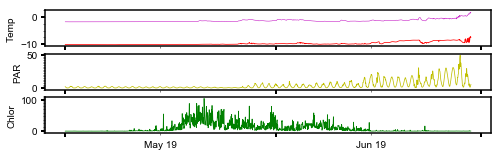

In [68]:
fig = plt.figure(1,figsize=(8,2.5))
### CTD Temperature
ax1a = plt.subplot(3, 1, 1)
plt.plot(ice_data.datetime,ice_data.topside_temp,'r',linewidth=.75)
plt.plot(ice_data.datetime,ice_data.underside_temp,'m',linewidth=.5)
ax1a.set_xticklabels([])
ax1a.set_ylabel('Temp')
### Par
ax1b = plt.subplot(3, 1, 2)
plt.plot(ice_data.datetime,ice_data.par,'y',linewidth=.75)
ax1b.set_xticklabels([])
ax1b.set_ylabel('PAR')
### Chlor
ax1c = plt.subplot(3, 1, 3)
plt.plot(ice_data.datetime,ice_data.fluor,'g',linewidth=.75)
ax1c.set_ylabel('Chlor')


## specify datelabels and ticks for all three pannels
ax1a.yaxis.set_minor_locator(ticker.MultipleLocator(2.5))
ax1a.xaxis.set_major_locator(DayLocator(bymonthday=1))
ax1a.xaxis.set_minor_locator(DayLocator(bymonthday=15))
ax1b.yaxis.set_minor_locator(ticker.MultipleLocator(2.5))
ax1b.xaxis.set_major_locator(DayLocator(bymonthday=1))
ax1b.xaxis.set_minor_locator(DayLocator(bymonthday=15))

ax1c.tick_params(labelbottom=True,labeltop=False)
ax1c.yaxis.set_minor_locator(ticker.MultipleLocator(2.5))
ax1c.xaxis.set_major_locator(DayLocator(bymonthday=1))
ax1c.xaxis.set_minor_locator(DayLocator(bymonthday=15))
ax1c.xaxis.set_major_formatter(ticker.NullFormatter())
ax1c.xaxis.set_minor_formatter(DateFormatter('%b %y'))
ax1c.xaxis.set_major_formatter(DateFormatter(''))
ax1c.xaxis.set_tick_params(which='major', pad=15)
ax1c.xaxis.set_tick_params(which='minor', pad=5)

fig.subplots_adjust(bottom=0.2)
fig.savefig(instid + '/'+year + '/' + instid+'_ice_data.png',dpi=300)

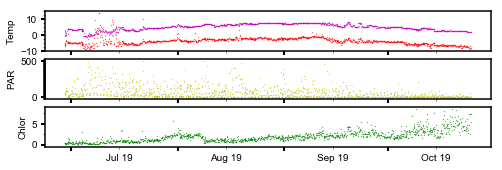

In [69]:
try:
    fig = plt.figure(1,figsize=(8,2.5))
    ### CTD Temperature
    ax1a = plt.subplot(3, 1, 1)
    plt.plot(sst_data.datetime,sst_data.topside_temp,'r.',markersize=.5,linewidth=.75)
    plt.plot(sst_data.datetime,sst_data.underside_temp,'m.',markersize=.5,linewidth=.5)
    ax1a.set_xticklabels([])
    ax1a.set_ylabel('Temp')
    ### Par
    ax1b = plt.subplot(3, 1, 2)
    plt.plot(sst_data.datetime,sst_data.par,'y.',markersize=.5,linewidth=.75)
    ax1b.set_xticklabels([])
    ax1b.set_ylabel('PAR')
    ### Chlor
    ax1c = plt.subplot(3, 1, 3)
    plt.plot(sst_data.datetime,sst_data.fluor,'g.',markersize=.5,linewidth=.75)
    ax1c.set_ylabel('Chlor')


    ## specify datelabels and ticks for all three pannels
    ax1a.yaxis.set_minor_locator(ticker.MultipleLocator(2.5))
    ax1a.xaxis.set_major_locator(DayLocator(bymonthday=1))
    ax1a.xaxis.set_minor_locator(DayLocator(bymonthday=15))
    ax1b.yaxis.set_minor_locator(ticker.MultipleLocator(2.5))
    ax1b.xaxis.set_major_locator(DayLocator(bymonthday=1))
    ax1b.xaxis.set_minor_locator(DayLocator(bymonthday=15))

    ax1c.tick_params(labelbottom=True,labeltop=False)
    ax1c.yaxis.set_minor_locator(ticker.MultipleLocator(2.5))
    ax1c.xaxis.set_major_locator(DayLocator(bymonthday=1))
    ax1c.xaxis.set_minor_locator(DayLocator(bymonthday=15))
    ax1c.xaxis.set_major_formatter(ticker.NullFormatter())
    ax1c.xaxis.set_minor_formatter(DateFormatter('%b %y'))
    ax1c.xaxis.set_major_formatter(DateFormatter(''))
    ax1c.xaxis.set_tick_params(which='major', pad=15)
    ax1c.xaxis.set_tick_params(which='minor', pad=5)

    fig.savefig(instid + '/'+year + '/' + instid+'_sst_data.png',dpi=300, tight_layout=True)
except:
    print("No SST Data yet")

In [70]:
sst_data

,time,pressure,topside_temp,topside_temp_ADC,underside_temp,underside_temp_ADC,temp_ref,par,fluor,tilt,...,GPSLat,GPSLon,GPSDate,GPSTime,TTF,Max_Tilt,datetime,id,dep_lat,dep_lon
1,1.561793e+09,0.031128,-6.642587,25082,1.935421,25169,8509,31.532904,0.404429,0,...,NaN,NaN,NaN,NaN,NaN,NaN,2019-06-29 07:30:53,300434063921240,71.222833,164.2613
2,1.561795e+09,0.030823,-6.086793,24351,2.554959,24399,8509,37.328041,0.385171,1,...,NaN,NaN,NaN,NaN,NaN,NaN,2019-06-29 07:51:03,300434063921240,71.222833,164.2613
3,1.561796e+09,0.031128,-5.973549,24205,2.933940,23941,8509,38.247904,0.365912,0,...,NaN,NaN,NaN,NaN,NaN,NaN,2019-06-29 08:15:27,300434063921240,71.222833,164.2613
4,1.561799e+09,0.032349,-5.758155,23930,0.183328,27498,8509,45.238863,0.365912,0,...,NaN,NaN,NaN,NaN,NaN,NaN,2019-06-29 09:04:25,300434063921240,71.222833,164.2613
5,1.561801e+09,0.032654,-5.414935,23499,-0.231422,28084,8509,68.493000,0.346654,0,...,NaN,NaN,NaN,NaN,NaN,NaN,2019-06-29 09:31:08,300434063921240,71.222833,164.2613
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1236,1.571936e+09,0.021057,-7.945586,26894,2.119828,24937,8509,-0.073589,4.583534,2,...,71.661056,-161.220431,241019.0,17005430.0,70.0,17965.0,2019-10-24 17:00:00,300434063921240,71.222833,164.2613
1237,1.571947e+09,0.020447,-8.843595,28228,2.151016,24898,8509,13.981918,7.395282,14,...,71.657688,-161.235359,241019.0,20001909.0,34.0,8720.0,2019-10-24 20:00:00,300434063921240,71.222833,164.2613
1238,1.571958e+09,0.022583,-7.134126,25749,2.214360,24819,8509,48.955110,2.638421,18,...,71.653224,-161.251343,241019.0,23005509.0,70.0,17961.0,2019-10-24 23:00:00,300434063921240,71.222833,164.2613
1239,1.571969e+09,0.022888,-8.426223,27599,2.210344,24824,8509,3.605863,7.260472,19,...,71.644384,-161.266527,251019.0,2004830.0,63.0,16166.0,2019-10-25 02:00:00,300434063921240,71.222833,164.2613
